# Pan Line 3 Coil Change Analysis
Dataset May 05, 2021 to December 02, 2025

1. Python configuration and requirements
   1. Create a Python virtual environment: `python3 -m venv ~/Python/venv/jupyter`
   2. Activate environment: `source ~/Python/venv/jupyter/bin/activate`
   3. Required packages are listed in *requirements.txt* file 
   4. Install required packages: `pip install -r requirements.txt`
2. Import Pan Line data and process: *data/Line 3 CoilUsage 2021_05_12-2025_12_02.csv*
   1. Set date data type for dates
   2. Extract year and day of year for production and load dates
   3.  Extract stile gauge from Haas Smart Part Number
   4.  Compare coil ID to previous to determine if the coil has changed
3.  Create a data field with unique coils per day and coil changes per day

In [1]:
# Constants
STILE_HEIGHT_18 = 18.0
STILE_HEIGHT_21 = 21.0
STILE_HEIGHT_24 = 24.0

STILE_WEIGHT_18 = 1.5
STILE_WEIGHT_21 = 2.0
STILE_WEIGHT_24 = 2.5

In [2]:
import pandas as pd
from IPython.display import Markdown as md

df = pd.read_csv('data/Line 3 CoilUsage 2021_05_12-2025_12_02.csv')

# # Set date type for date columns
df['DateTimeStamp'] = pd.to_datetime(df['DateTimeStamp'])
df['LoadDate'] = pd.to_datetime(df['LoadDate'])

# # Extract day of year and year from date columns
df['DayOfYear'] = df['DateTimeStamp'].dt.dayofyear
df['LoadDayOfYear'] = df['LoadDate'].dt.dayofyear
df['LoadYear'] = df['LoadDate'].dt.year
df['Year'] = df['DateTimeStamp'].dt.year
df['Month'] = df['DateTimeStamp'].dt.month

# # Make a column for the stile gauge
df['StileGauge'] = df['SectionNumber'].str[12:13]

# # Make a copy of the CoilId column and shift down by one
# # then compare to see if the coil changed
df['IsCoilChange'] = df['HaasCoilNum'].shift(1) != df['HaasCoilNum']

# Get the 'Outside Panel Treatment' and 'Backer/Stile Placement Option' characters from the SectionNumber
df['StileCode'] = (df['SectionNumber'].str[8] + df['SectionNumber'].str[19])

# Get the 'Section Height' from the SectionNumber
df['SectionHeight'] = pd.to_numeric(df['SectionNumber'].str[1:3])

# Get the 'Section Length' from the SectionNumber
df['SectionLength'] = pd.to_numeric(df['SectionNumber'].str[14:16]) * 12 + pd.to_numeric(df['SectionNumber'].str[16:18])

# Generate summary markdown
data_preview = f"""
### Data Preview
There are {len(df)} pan sections across {df['Year'].nunique()} years. Below is a table of the first five rows of the DataFrame:
{df.head(5).to_markdown(index=False)}
"""

# export the df to csv file
df.to_csv('data/modified_coil_section_data.csv', index=False)

display(md(data_preview))


### Data Preview
There are 1060346 pan sections across 5 years. Below is a table of the first five rows of the DataFrame:
| DateTimeStamp              | SectionNumber                  | HaasCoilNum                 | LoadDate            |   DayOfYear |   LoadDayOfYear |   LoadYear |   Year |   Month |   StileGauge | IsCoilChange   | StileCode   |   SectionHeight |   SectionLength |
|:---------------------------|:-------------------------------|:----------------------------|:--------------------|------------:|----------------:|-----------:|-------:|--------:|-------------:|:---------------|:------------|----------------:|----------------:|
| 2021-05-12 00:00:08.607000 | T21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 |         132 |             133 |       2021 |   2021 |       5 |            5 | True           | SS          |              21 |             120 |
| 2021-05-12 00:00:35.673000 | B21PW-DBSS-N5-1000NS-NNNNN-NXL | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 |         132 |             133 |       2021 |   2021 |       5 |            5 | False          | SS          |              21 |             120 |
| 2021-05-12 00:01:03.290000 | I21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 |         132 |             133 |       2021 |   2021 |       5 |            5 | False          | SS          |              21 |             120 |
| 2021-05-12 00:01:31.227000 | I21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 |         132 |             133 |       2021 |   2021 |       5 |            5 | False          | SS          |              21 |             120 |
| 2021-05-12 00:01:58.243000 | T21PW-DBSS-N5-1000NS-NNNNN-NXN | PW-SC-DS-17-27.200-00044987 | 2021-05-13 00:00:00 |         132 |             133 |       2021 |   2021 |       5 |            5 | False          | SS          |              21 |             120 |


| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |    nan |    615 |    752 |    751 |    733 |
| Feb     |    nan |    608 |    671 |    590 |    530 |
| Mar     |    nan |    732 |    808 |    557 |    650 |
| Apr     |    nan |    601 |    740 |    612 |    598 |
| May     |    427 |    755 |    889 |    818 |    716 |
| Jun     |    493 |    758 |    887 |    632 |    749 |
| Jul     |    440 |    694 |    757 |    648 |    724 |
| Aug     |    636 |    935 |    832 |    605 |    667 |
| Sep     |    500 |    798 |    750 |    612 |    702 |
| Oct     |    535 |    844 |    857 |    720 |    770 |
| Nov     |    545 |    754 |    626 |    642 |    690 |
| Dec     |    462 |    600 |    494 |    535 |     79 |

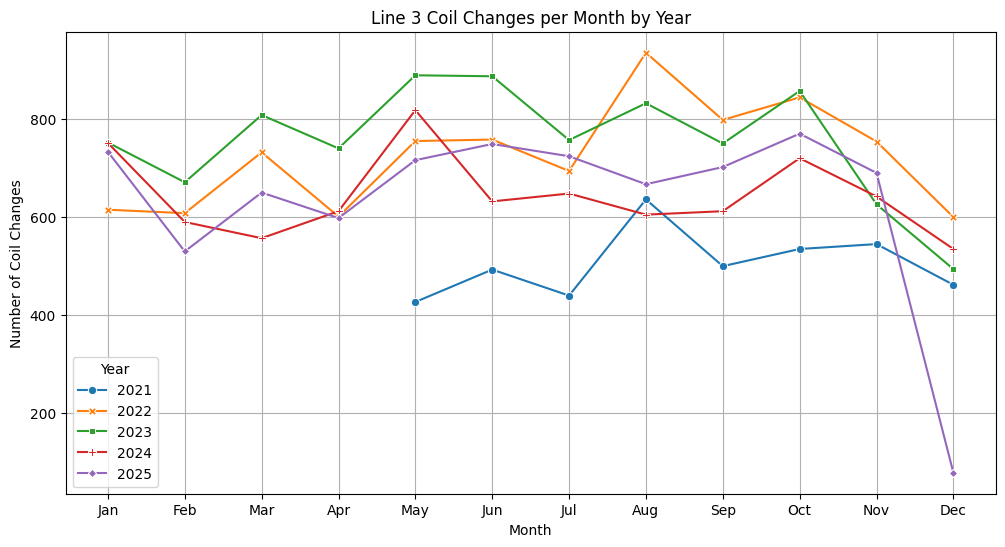

In [3]:
# # Count the number of unique coils used per day of each year
unique_coils_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)['HaasCoilNum'].nunique()

# Count the number of coils changed per day of each year
coils_changed_per_day_year = df.groupby(by=['Year', 'DayOfYear'], group_keys=True)['IsCoilChange'].sum()

# Merge the two series into the DataFrame
coil_changes_year = pd.merge(unique_coils_per_day_year, coils_changed_per_day_year, on=['Year', 'DayOfYear'], suffixes=('_UniqueCoils', '_CoilsChanged'))
coil_changes_year = coil_changes_year.rename(columns={'HaasCoilNum': 'Unique Coils', 'IsCoilChange': 'Coils Changed'})

# Create a dataframe showing the total coil changes per month for each year
coil_changes_month = df.groupby(by=['Year', 'Month'], group_keys=True)['IsCoilChange'].sum().unstack(level=0)
coil_changes_month.index = coil_changes_month.index.map(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))  

display(md(coil_changes_month.to_markdown()))
import seaborn as sns
import matplotlib.pyplot as plt

# graph comparing years of coil changes per month
plt.figure(figsize=(12, 6))
sns.lineplot(data=coil_changes_month, markers=True, dashes=False)
plt.title('Line 3 Coil Changes per Month by Year')
plt.xlabel('Month')
plt.ylabel('Number of Coil Changes')
plt.legend(title='Year')
plt.grid()
plt.show()

| Month   |   2021 |   2022 |   2023 |   2024 |   2025 |
|:--------|-------:|-------:|-------:|-------:|-------:|
| Jan     |    nan |    146 |    134 |    140 |    143 |
| Feb     |    nan |    144 |    133 |    120 |    117 |
| Mar     |    nan |    157 |    150 |    112 |    134 |
| Apr     |    nan |    144 |    142 |    118 |    129 |
| May     |    116 |    148 |    167 |    162 |    138 |
| Jun     |    113 |    155 |    153 |    134 |    146 |
| Jul     |    105 |    146 |    137 |    122 |    146 |
| Aug     |    153 |    164 |    149 |    139 |    135 |
| Sep     |    148 |    141 |    133 |    128 |    144 |
| Oct     |    115 |    158 |    156 |    150 |    149 |
| Nov     |    124 |    127 |    136 |    141 |    148 |
| Dec     |    120 |    123 |    117 |    122 |     47 |

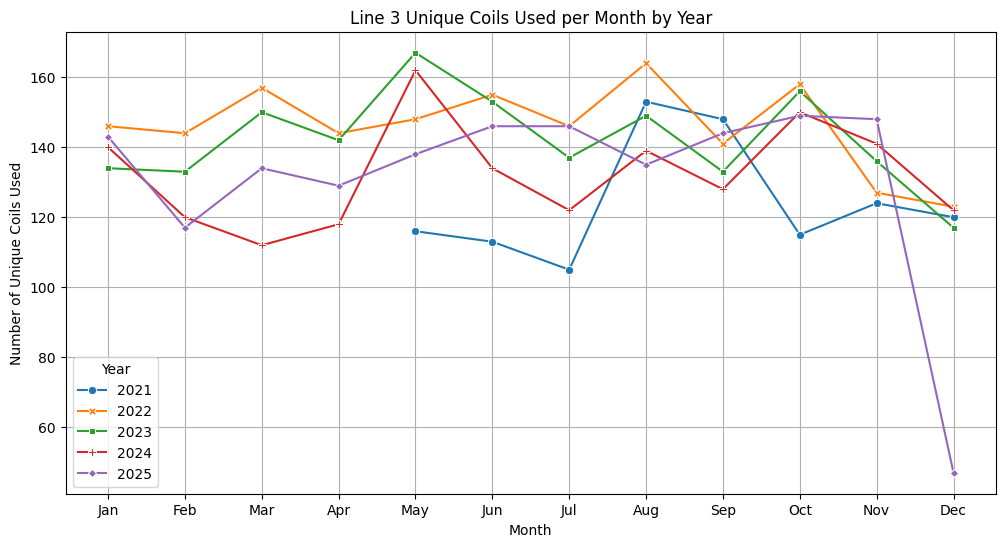

In [4]:
# Create a dataframe showing the number of unique coils used per month for each year
unique_coils_month = df.groupby(by=['Year', 'Month'], group_keys=True)['HaasCoilNum'].nunique().unstack(level=0)
unique_coils_month.index = unique_coils_month.index.map(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))   
display(md(unique_coils_month.to_markdown()))
# graph comparing years of unique coils used per month
plt.figure(figsize=(12, 6))
sns.lineplot(data=unique_coils_month, markers=True, dashes=False)
plt.title('Line 3 Unique Coils Used per Month by Year')
plt.xlabel('Month')
plt.ylabel('Number of Unique Coils Used')
plt.legend(title='Year')
plt.grid()
plt.show()

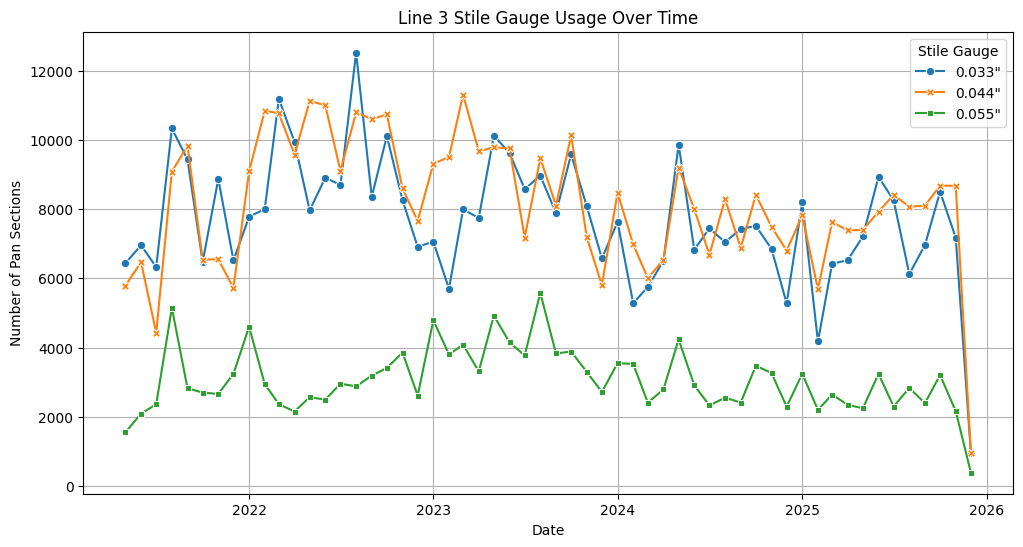

In [5]:
# Create a dataframe showing stile gauge usage over time from May 2021 to Dec 2025
stile_gauge_usage = df.groupby(by=['DateTimeStamp', 'StileGauge'], group_keys=True)['SectionNumber'].count().unstack(level=1).fillna(0)
stile_gauge_usage = stile_gauge_usage.rename(columns=lambda x: f'0.0{x}{x}"')
stile_gauge_usage = stile_gauge_usage.resample('ME').sum()
stile_gauge_usage.index = stile_gauge_usage.index.to_period('M').to_timestamp()
# graph stile gauge usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_gauge_usage, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Pan Sections')
plt.legend(title='Stile Gauge')
plt.grid()
plt.show()

StileGauge        0.033"     0.044"     0.055"
DateTimeStamp                                 
2021-05-01     46.747495  41.999419  11.253086
2021-06-01     44.824030  41.697821  13.478149
2021-07-01     48.275599  33.725011  17.999390
2021-08-01     42.063266  36.982453  20.954281
2021-09-01     42.713568  44.515370  12.771063


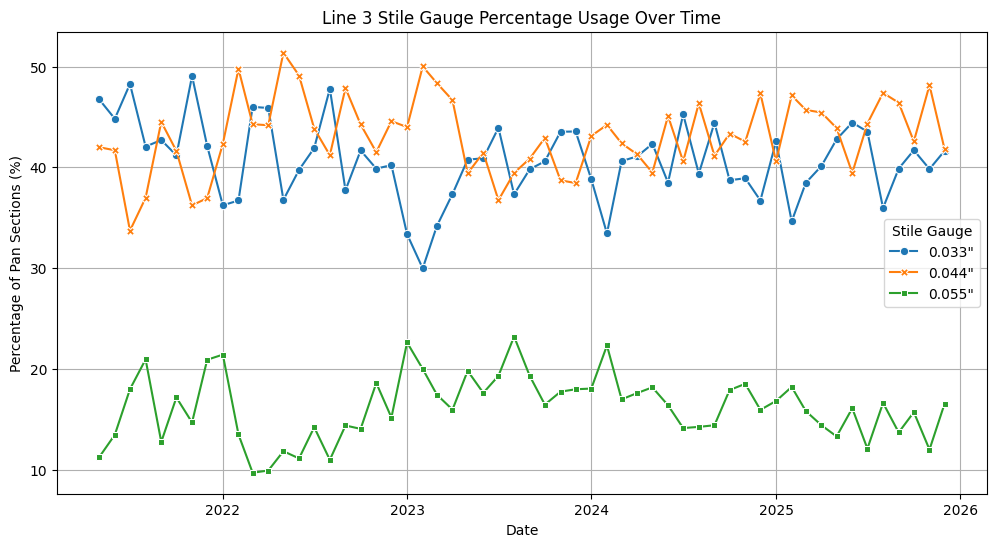

In [6]:
# Create a dataframe showing the percentage of stile gauge usage over time
stile_gauge_percentage = stile_gauge_usage.div(stile_gauge_usage.sum(axis=1), axis=0) * 100
print(stile_gauge_percentage.head())
# graph stile gauge percentage usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=stile_gauge_percentage, markers=True, dashes=False)
plt.title('Line 3 Stile Gauge Percentage Usage Over Time') 
plt.xlabel('Date')
plt.ylabel('Percentage of Pan Sections (%)')
plt.legend(title='Stile Gauge')
plt.grid()
plt.show()  


In [9]:
# Make a list of all the unique StileCodes
unique_stile_codes = df['StileCode'].unique()

# Check the file 'data/PANEL LOCATIONS (LINE 3) Rev 03_20.xlsx' to see if it 
# has sheet name for each of the unique stile codes ex. 'BA-SS', 'BB-SS', etc.

# Create an ExcelFile object
xls_file = 'data/PANEL LOCATIONS (LINE 3) Rev 03_20.xlsx'
xls = pd.ExcelFile(xls_file)

# Get the list of sheet names
sheet_names = xls.sheet_names

# Create an empty dictionary to hold the data for each stile code
stile_dataframes = {}

# Make a list of orphan stile codes
orphan_stile_codes = []

# For each unique stile code, check if there is a corresponding sheet in the Excel file
# if there is, get the stile counts for each length and add to the stile dictionary
for stile_code in unique_stile_codes:
    if stile_code + "-SS" in sheet_names:
        # add the excel tab length/stile count data to the dictionary
        stile_dataframes[stile_code + "-SS"] = xls.parse(sheet_name=stile_code + "-SS", usecols=[2,3], header=None, names=['Length', stile_code + "-SS"], skiprows=4)
        stile_dataframes[stile_code + "-SS"].set_index('Length', inplace=True)
    else:
        print(f"Sheet {stile_code}-SS does NOT exist. Adding to orphan stile codes.")
        orphan_stile_codes.append(stile_code)
 
# Concatenate all the stile dataframes into a single stile key table
stile_key_table = pd.concat(stile_dataframes.values(), axis=1)

# Get all the rows from df where there is no corresponding stile code sheet
orphan_stile_df = df[df['StileCode'].isin(orphan_stile_codes)]
orphan_stile_df.to_csv('data/orphan_stile_codes.csv', index=False)
print(f"There were {len(orphan_stile_df)} sections with orphan stile codes added to the report: 'data/orphan_stile_codes.csv.'")

Sheet SJ-SS does NOT exist. Adding to orphan stile codes.
Sheet RW-SS does NOT exist. Adding to orphan stile codes.
There were 9 sections with orphan stile codes added to the report: 'data/orphan_stile_codes.csv.'
